The goal is to estimate the cost of a New York City cab ride from several inputs. The data is taken from NYC cab fare prediction <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a>.

Perform following steps
<ol>
    <li> Perform Feature Engineering</li>
    <ol>
        <li> calculate the distance from give latitude and longitude</li>
        <li> convert the pickup_datetime to date_time object</li>
        <li> convert the date time to newyork time </li>
        <li> get day of week, hour of the day, am/pm </li>
        
</ol>


In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import time

In [3]:
#took a very small section of data 120k rows from 5.5 millions rows

df = pd.read_csv('../Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
# df["dropoff_longitude"]

Calculate the Haversine Distance: istance on a sphere between two sets of GPS coordinates

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

$\varphi$ is latitude

$\lambda$ is longitude

$r$ is the radius, here earth's radius that is appox 6371 km


In [5]:
r = 6371

In [6]:
##super slow version as the apply function runs over each row seperatly --8 sec!!!!
def haversine_distance(df):
    
    phi2 = np.radians(df["dropoff_latitude"])
    phi1 = np.radians(df["pickup_latitude"])
    del_phi = np.radians(df["dropoff_latitude"] - df["pickup_latitude"])
    del_lambda = np.radians(df["dropoff_longitude"] - df["pickup_longitude"])
    
    term1 = np.sin(del_phi/2)**2 + np.cos(phi1) * np.cos(phi2) \
            * np.sin(del_lambda /2)**2
#     print(term1)
    term2 = 2 * np.arctan2(np.sqrt(term1), np.sqrt(1-term1))
    result = (r * term2)
    return result
    
start_time = time.time()
df["distance"] = df.apply(haversine_distance,axis=1)
df.head()
print(f'\nDuration: {time.time() - start_time:.0f} seconds')


Duration: 14 seconds


In [7]:
#super fast as it is doing matrix operations in numpy -> 0.02 seconds!! 400 times faster
def haversine_distance(df,drop_lat,drop_long,pick_lat,pick_long):
    
    phi2 = np.radians(df[drop_lat])
    phi1 = np.radians(df[pick_lat])
    
    del_phi = np.radians(df[drop_lat] - df[pick_lat])
    
    del_lambda = np.radians(df[drop_long] - df[pick_long])
    
    term1 = np.sin(del_phi/2)**2 + np.cos(phi1) * np.cos(phi2) \
            * np.sin(del_lambda /2)**2
#     print(term1)
    term2 = 2 * np.arctan2(np.sqrt(term1) , np.sqrt(1-term1))
    result = (r * term2)
    return result

start_time = time.time()
df["distance"] = haversine_distance(df,"dropoff_latitude","dropoff_longitude"\
                                    ,"pickup_latitude","pickup_longitude")
df.head()
print(f'\nDuration: {time.time() - start_time:.10f} seconds')


Duration: 0.0465312004 seconds


In [8]:
# convert the pickup_datetime to date_time object
df["nyc_datetime"] = pd.to_datetime(df['pickup_datetime'].str[:-3]) - pd.Timedelta(hours=4)
print(type(df["nyc_datetime"][0]))
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,nyc_datetime
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01


In [9]:
#get hours
df["Hour"] = df["nyc_datetime"].dt.hour
df.head(2)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,nyc_datetime,Hour
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11


In [10]:
#get the am am feature

# df["AMorPM"] = np.where(df["Hour"]<12 ,"am", "pm")
#both are same
df["AMorPM"] = df["nyc_datetime"].dt.strftime("%p").str.lower()
df.head(5)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,nyc_datetime,Hour,AMorPM
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm


In [11]:
# get the weekday feature

df["Weekday"] = df["nyc_datetime"].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,nyc_datetime,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


### taking the hour, weekday and am/pm as categorical data

In [12]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'nyc_datetime', 'Hour', 'AMorPM',
       'Weekday'],
      dtype='object')

In [13]:
categorical_cols = ['Hour', 'AMorPM','Weekday']
continuous_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance']
y_cols = ['fare_amount'] #final value to be predicted

### convert the categorical columns into categories

In [14]:
print(df['AMorPM'][:5],df['AMorPM'][:5].astype('category'))
df.head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: object 0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]


,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,nyc_datetime,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [15]:
for cats in categorical_cols:
    df[cats]= df[cats].astype('category')

In [16]:
df["AMorPM"].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [61]:
df["Weekday"].cat.categories ,df["Weekday"].head().cat.codes.values

(Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object'),
 array([1, 2, 2, 3, 0], dtype=int8))

### combine the codes columns into one input array using np.stack, only the values

In [18]:
hr=df["Hour"].cat.codes.values
ap =df["AMorPM"].cat.codes.values
week=df["Weekday"].cat.codes.values

print(hr[:5],week[:5],ap[:5])

cats = np.stack([hr,ap,week] , axis =1) #columnwise

print(cats[:5])

cats_row = np.stack([hr,ap,week] , axis =0) #rowwise

print(cats_row[:5])

[ 4 11  7 17 22] [1 2 2 3 0] [0 0 0 1 1]
[[ 4  0  1]
 [11  0  2]
 [ 7  0  2]
 [17  1  3]
 [22  1  0]]
[[ 4 11  7 ... 14  4 12]
 [ 0  0  0 ...  1  0  1]
 [ 1  2  2 ...  3  5  2]]


### Convert the numpy arrays into tensors

In [58]:
cats = torch.tensor(cats,dtype=torch.int64)
cats[0].dtype

C:\Users\shashan3\Anaconda3\envs\pytorchenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.int64

Also convert the continues variables into torch tensors
##### It is important to store the continuous features into Float (float32) tensors and not Double (float64) in order for the batch normalization to work properly 

In [20]:
conts = np.stack([df[col] for col in continuous_cols], axis=1)
conts = torch.tensor(conts, dtype=torch.float)

conts[:5]

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        [-73.9905,  40.7564, -73.9712,  40.7482,   1.0000,   1.8641],
        [-73.9910,  40.7342, -73.9060,  40.7431,   1.0000,   7.2313]])

In [21]:
cats.type(),conts.type(),type(cats[0].type()),cats.dtype,conts.dtype

('torch.LongTensor', 'torch.FloatTensor', str, torch.int64, torch.float32)

get torch tensors for the fare amount 

In [56]:
y=torch.tensor(df["fare_amount"],dtype=torch.float).reshape(-1,1)
y.shape,y.requires_grad

(torch.Size([120000, 1]), False)

In [23]:
cats.shape,conts.shape,y.shape

(torch.Size([120000, 3]), torch.Size([120000, 6]), torch.Size([120000, 1]))

In [24]:
cats[:3],conts[:3],y[:3]

(tensor([[ 4,  0,  1],
         [11,  0,  2],
         [ 7,  0,  2]]),
 tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
         [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
         [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268]]),
 tensor([[ 6.5000],
         [ 6.9000],
         [10.1000]]))

# Embedding the categorical data with tensor

Docstring of nn.Embedding module

nn.Embedding( <br>
&nbsp;&nbsp;&nbsp;&nbsp;num_embeddings: int, size of the dictionary of embeddings that is the number of distinct number that need to be encoded<br> 
&nbsp;&nbsp;&nbsp;&nbsp;embedding_dim: int, the size of each embedding vector<br>
&nbsp;&nbsp;&nbsp;&nbsp;padding_idx: Union[int, NoneType] = None,
&nbsp;&nbsp;&nbsp;&nbsp;max_norm: Union[float, NoneType] = None,
&nbsp;&nbsp;&nbsp;&nbsp;norm_type: float = 2.0,
&nbsp;&nbsp;&nbsp;&nbsp;scale_grad_by_freq: bool = False,
&nbsp;&nbsp;&nbsp;&nbsp;sparse: bool = False,
&nbsp;&nbsp;&nbsp;&nbsp;_weight: Union[torch.Tensor, NoneType] = None,
) -> None

Docstring:     
A simple lookup table that stores embeddings of a fixed dictionary and size.

This module is often used to store word embeddings and retrieve them using indices.
The input to the module is a list of indices, and the output is the corresponding
word embeddings.

In [70]:
e=nn.Embedding(24,5)
e(torch.tensor([0]))# more than 24 will give error as it will be out of index

tensor([[ 0.1615,  0.9810,  0.3105, -0.9346, -0.2074]],
       grad_fn=<EmbeddingBackward>)

now we need to define such embeddings and their dimesions for each of our categorical data

In [26]:
# the dimension size should not be more than 50 (ideally) ie 2^50 amount of information
print(df.columns)
print(df["Weekday"].cat.categories)

#get the number of embedding for each category
cat_size= [len(df[col].cat.categories) for col in categorical_cols]
cat_size

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'nyc_datetime', 'Hour', 'AMorPM',
       'Weekday'],
      dtype='object')
Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')


[24, 2, 7]

In [27]:
#get number of dimension for each category
emb_size = [(i , min(50 ,(i+1)//2)) for i in cat_size]
emb_size

[(24, 12), (2, 1), (7, 4)]

### example of how it is going to work inside model

In [28]:
selfembeds = nn.ModuleList([nn.Embedding(number_of_embedding,number_of_dimension) for \
                          number_of_embedding,number_of_dimension in emb_size])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [29]:
list(enumerate(selfembeds)),selfembeds[0],selfembeds[0](torch.tensor([3]))

([(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))],
 Embedding(24, 12),
 tensor([[ 0.6534,  2.5833, -1.0405,  1.1125, -0.3514, -0.2169, -0.0081, -1.6349,
           0.8916, -1.5650,  0.5846,  0.1808]], grad_fn=<EmbeddingBackward>))

In [30]:
ct = cats[:1]
print(ct)
embeddingz=[]
for i ,embd in enumerate(selfembeds):
    embs = embd(ct[:,i])
    embeddingz.append(embs)
    print(i,ct[:,i],embs)

tensor([[4, 0, 1]])
0 tensor([4]) tensor([[ 0.1071, -0.2859,  0.9970, -0.9753,  0.5367,  1.3498,  0.1269,  0.0713,
          1.5402,  2.0045,  0.2895,  0.8638]], grad_fn=<EmbeddingBackward>)
1 tensor([0]) tensor([[2.0180]], grad_fn=<EmbeddingBackward>)
2 tensor([1]) tensor([[ 0.2905,  0.3134, -0.8809, -0.0032]], grad_fn=<EmbeddingBackward>)


now concatenate the different embeddings dimensions (12,1,4) into one (17)

In [31]:
z = torch.cat(embeddingz,axis=1)
z,z.shape

(tensor([[ 0.1071, -0.2859,  0.9970, -0.9753,  0.5367,  1.3498,  0.1269,  0.0713,
           1.5402,  2.0045,  0.2895,  0.8638,  2.0180,  0.2905,  0.3134, -0.8809,
          -0.0032]], grad_fn=<CatBackward>),
 torch.Size([1, 17]))

### set the drop outs



Init signature: nn.Dropout(p: float = 0.5, inplace: bool = False) -> None <br>
Docstring:     <br>
During training, randomly zeroes some of the elements of the input
tensor with probability :attr:`p` using samples from a Bernoulli
distribution. Each channel will be zeroed out independently on every forward
call.

This has proven to be an effective technique for regularization and
preventing the co-adaptation of neurons as described in the paper
`Improving neural networks by preventing co-adaptation of feature
detectors`_ .

In [32]:
dropouts =nn.Dropout(.4)

In [33]:
z,dropouts(z)

(tensor([[ 0.1071, -0.2859,  0.9970, -0.9753,  0.5367,  1.3498,  0.1269,  0.0713,
           1.5402,  2.0045,  0.2895,  0.8638,  2.0180,  0.2905,  0.3134, -0.8809,
          -0.0032]], grad_fn=<CatBackward>),
 tensor([[ 0.1785, -0.0000,  1.6617, -0.0000,  0.0000,  0.0000,  0.0000,  0.1189,
           0.0000,  3.3408,  0.4825,  1.4397,  3.3633,  0.4841,  0.5223, -1.4682,
          -0.0000]], grad_fn=<MulBackward0>))

In [34]:
nn.BatchNorm1d

torch.nn.modules.batchnorm.BatchNorm1d

nn.ReLU
nn.BatchNorm1d

$y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$


$\gamma$ and $\beta$ are learnable parameter vectors
of size `C` (where `C` is the input size)

# Define model

In [35]:
class TabModel(nn.Module):
    def __init__(self, emb_size, continuous_dim, output_sz, layers, p=0.5):
        
        """
        emb_size: List of tuples -> with unique number of categories and number of dimension
        for each categorical feature

        continuous_dim: int -> number of dimesion of the continuous features, all combined

        output_sz: int -> number of outputs, size of last layer,

        layer: list of int -> list of dimension of each layer, len of layers is the number of layers

        p: float -> dropout probability
        """         
        super().__init__()

        #embedding for categorical data in forward pass
        self.embs = nn.ModuleList([nn.Embedding(n_unique_cats, n_dimension) for n_unique_cats,\
                                   n_dimension in emb_size])
        
        #dimension of embeddings of categorical data
        n_cats_emb = np.sum([n_dimension for _,n_dimension in emb_size])
        
        #dropout layer for categorical data
        self.emb_drop = nn.Dropout(p)
        
        #normalization function for continuous variables - use this in forward pass
        self.cont_batchnorm_layer = nn.BatchNorm1d(continuous_dim)
        
        #dimension of input vector-> combined features 
        n_dim = n_cats_emb + continuous_dim
        
        #list with hold the layer in the NN
        layerslist = []
        
        #itererate over the layers list, itj item is the number of neurons in ith layes
        for i in layers:
            layerslist.append(nn.Linear(n_dim,i)) #linear layer
            layerslist.append(nn.ReLU(inplace=True)) #RelU
            layerslist.append(nn.BatchNorm1d(i)) #Batch Noramlization
            layerslist.append(nn.Dropout(p)) #Dropout layer with given p
            n_dim = i #set the input for next layer
    
        layerslist.append(nn.Linear(layers[-1],output_sz))#last layer
        self.layers = nn.Sequential(*layerslist)
            
    def forward(self,x_cat,x_cont):
        embeddings = []
        #perform steps explained earlier to embed the categorical features
        for i,emb in enumerate(self.embs):
            embeddings.append(emb(x_cat[:,i]))
        #cancatenate the cat embeddings
        x = torch.cat(embeddings, axis =1)
        
        #dropouts on the cats embeddings
        x = self.emb_drop(x)
        
        #batch normalization on the continuous features
        x_cont = self.cont_batchnorm_layer(x_cont)
        
        #concatenate the both cat and cont features
        x = torch.cat([x,x_cont],axis =1)
        
        #forward pass with the architecture defined in __init__
        x = self.layers(x)
        
        #eturn the outcome of the last layer
        return x
        

In [36]:
#initiate the model
model = TabModel(emb_size, conts.shape[1], 1, [200,100], p=0.4)
model

TabModel(
  (embs): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (cont_batchnorm_layer): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [54]:
for i in model.parameters():
    print(i.shape,i.dtype,i.requires_grad)

torch.Size([24, 12]) torch.float32 True
torch.Size([2, 1]) torch.float32 True
torch.Size([7, 4]) torch.float32 True
torch.Size([6]) torch.float32 True
torch.Size([6]) torch.float32 True
torch.Size([200, 23]) torch.float32 True
torch.Size([200]) torch.float32 True
torch.Size([200]) torch.float32 True
torch.Size([200]) torch.float32 True
torch.Size([100, 200]) torch.float32 True
torch.Size([100]) torch.float32 True
torch.Size([100]) torch.float32 True
torch.Size([100]) torch.float32 True
torch.Size([1, 100]) torch.float32 True
torch.Size([1]) torch.float32 True


# Loss and optimizer

In [38]:
#since this is a regression problem we will define the loss as Rootmeansquare, 
# apply torch.sqrt() fucntion to the output of nn.MSELoss() 
criterion = nn.MSELoss()

#will use Adam optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)



In [39]:
print(conts.shape)

cats.shape # the embeddings for this will be learned

torch.Size([120000, 6])


torch.Size([120000, 3])

## create test train split

In [40]:
batch_size = 60000
test_size = int(batch_size * 0.2)

In [41]:
#categorical features
cat_train = cats[:batch_size - test_size]
print(cat_train.shape)
cat_test = cats[batch_size - test_size:batch_size]
print(cat_test.shape,len(cat_test))

#continuous features
cont_train = conts[:batch_size - test_size]
print(cont_train.shape)
cont_test = conts[batch_size-test_size: batch_size]
print(cont_test.shape)

#labels
y_train = y[:batch_size - test_size]
print(y_train.shape)
y_test =y[batch_size-test_size: batch_size]
print(y_test.shape)

torch.Size([48000, 3])
torch.Size([12000, 3]) 12000
torch.Size([48000, 6])
torch.Size([12000, 6])
torch.Size([48000, 1])
torch.Size([12000, 1])


### Training

In [42]:
start_time = time.time()
#number of epochs
epochs=100
#list to accumulate losses at each epoch
losses=[]

for epoch in range(epochs):
    #forward pass
    y_pred = model.forward(cat_train,cont_train)
    
    # square root to get RMSE
    loss = torch.sqrt(criterion(y_pred, y_train)) 
    
    #append the loss to losses
    losses.append(loss)
    
    if epoch%10==0:
        print(f"epoch: {epoch}, loss: {loss:.3f}")
    
    #clear the gradients
    optimizer.zero_grad()
    
    #backpropogation
    loss.backward()
    
    #update the weights
    optimizer.step()
    

epoch: 0, loss: 12.607
epoch: 10, loss: 9.682
epoch: 20, loss: 7.925
epoch: 30, loss: 4.791
epoch: 40, loss: 4.141
epoch: 50, loss: 3.560
epoch: 60, loss: 3.469
epoch: 70, loss: 3.421
epoch: 80, loss: 3.342
epoch: 90, loss: 3.333


### plot error

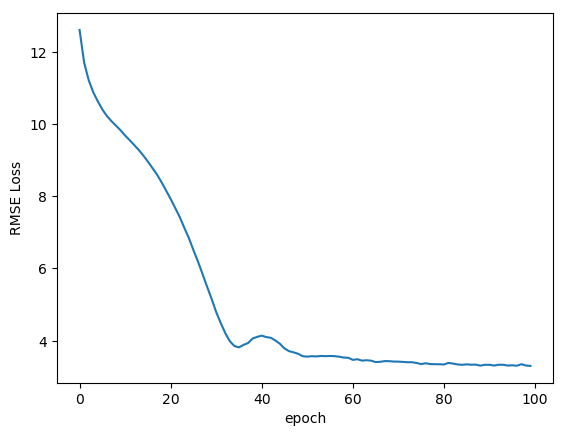

In [44]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

### validate- check test accuracy

In [46]:

with torch.no_grad():
    y_val = model(cat_test, cont_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.21793723
